# midinet2モデルの学習
midinet2は楽曲のより詳細な情報を条件として受け入れられるようにしたmidinetベースの音楽生成GAN

## midinet2 最終的な工夫のまとめ
モデルの大胆な変更は行わず，小手先のテクニックでどこまでうまくいけるかを試した  
聴ける曲を作るには，モデルや学習手法よりも前処理が肝要であった．  
最終的に，ただのmidinetよりはメロディらしさが増し，人が作るようなフレーズも散見されるようになった．

### 前処理
- 全体的なこと
    - スケール外の音を学習しないよう，トランスポーズによる水増しを行わない
        - これによりスケール外の音を使用することはほとんどなくなった
- メロディのこと
    - 1拍のステップ数を4->12とし，3連符や音符の切れ目にも対応
        - 実際，長く学習を進めれば音符の切れ目を作ってくれるようになった
    - 最もメロディに合致するkeyを推定し，key=Cへトランスポーズ
        - データセットで提示されているスケールは合っていないことがあった
        - これによりスケール外の音を使用することはほとんどなくなった
    - MIDI音程をデータの9割方が含まれる64音程に限定
    - さらに2オクターブ内に音程を押し込めた
        - これにより極端な音飛びが発生しにくくなった
    - 「何も鳴らさなければ偽物とバレない」をさせないため9割以上が音符を含む小節のみを学習
        - これにより学習を長く進めても空の小節を作ることはほとんどなくなった
- コードのこと
    - 1小節に複数のコードがあることに対応するため，拍ごとの先頭コード4つを連結し48次元に
    - ここでそれぞれの拍はコードのルートではなく，構成音をそのままベクトルに使用
        - 効果があったのかはよくわからないが，構成音を使う時の方が多い気もする
- セクションのこと
    - コードベクトルに6次元のセクション情報を加えた．
        - これはあまり効果があったようには思えない

### モデル(midinet2)
- G,Dともにカーネルサイズ(3,1)の畳み込み/逆畳み込み層を追加
    - 1拍4×3=12ステップの小節データに対応
    - 学習が甘いと細かい音符を拡散させてしまうが，学習を進めれば鳴らす音符は1つに定まってくる
- コンストラクタでノイズベクトルのサイズを受け取る
    - モデルのパラメータ数を初期化時に決められる
    - 条件ベクトルが5倍くらいになったので，ノイズベクトルも512と約5倍にした

### 学習方法
- Noisy Label: Dの学習時ラベルを乱数で求めることでDが強くなりすぎたり過学習するのを防ぐ
    - 本物データに対しては0.7～1.2, 偽物データに対しては0～0.3
- feature mappingによるペナルティが軽すぎたのでせめて$\lambda_1=0.1, \lambda_2=0.5$と大きくした
    - そもそもfeature mappingがうまく働いているのかわからない
- Gの学習時，ノイズベクトルは毎回新しいものを使用
    - 経験的に明らかに結果が良くなった
- Dの学習1回に対するGの学習回数は，「本物を本物と見分けられる優秀なDに偽物だと見抜かれるならGはその分がんばる」という方法で回数を動的に決定
    - 具体的には，(realD - fakeD) × 100 × k (kは大きいほど回数を増やすHP)
    - Dの学習が進んでないうちにGが置いてけぼりにしたり，Dに勝てなくなったりすることが少なくなった
    - 学習後半では結局Dに段々負けていってしまっているが，結果の曲は結構いい

### 後処理
- ステップごとの最大値のみを鳴らすmonophonize(これは本家もやっていた)
- ステップ内の出力結果の値が全て閾値を越えなければ休符とみなす
    - 学習が進んだモデルはほとんど出力結果が1と0に分かれるのであまり必要でない
    - 出力マップを直接imshowで観察するshow_mapでも精度が良い(鳴らす音符がほとんど一つに定まる)ことが確認されている
- 16分音符などのちょうどいい大きさの音符にDownResolutionするfill
    - 細かい音符を消し去るのが目的
    - その新しいステップの終端が空白なら音符の切れ目と判断して削る
- 細かい音符を直接消し去るremove_short_notes
    - 学習が進んだモデルを使えばfillだけで十分
- 学習の条件となる譜面を作成するだけでなく，トランスポーズやオーディオ化，視聴，MIDI化が簡単にできるNotebookを作成

### まとめと展望
上記のことをやったが，やはり前の小節一つのみを条件に使うのでは，フレーズの繰り返しなどを表現することができず，落ち着かない感じになってしまう．  
以降では，次のような手法を用い，モデルそのものの改良を行っていく
- より長大なデータを入力できると期待されるSelf-Attention
- ランダムノイズが少なくてもモード崩壊を防げるWGAN, WGAN-gpの導入

In [2]:
import os, glob, ipdb, pickle, numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from PIL import Image
from utils import Timer, get_model
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
base_dir = "../datasets/theorytab/midinet"
output_dir = f"{base_dir}/learning"

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## DataLoaderの作成

In [4]:
class MidinetDataloader():
    def __init__(self, data_path, pitch_range=[0, 64], show_shape=False):
        data = pickle.load(open(data_path,'rb'))
        
        melody, prev, chord = [], [], []
        for m, p, c in data:
            melody.append(m)
            prev.append(p)
            chord.append(c)
        
        self.size = len(melody)
        steps = len(melody[0])
        bottom, top = pitch_range
        
        melody = np.array(melody)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        prev = np.array(prev)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        chord = np.array(chord)
        
        if show_shape:
            print("melody shape", melody.shape)
            print("prev shape", prev.shape)
            print("condition shape", chord.shape)
        
        self.x = torch.from_numpy(melody).float()
        self.prev_x   = torch.from_numpy(prev).float()
        self.y  = torch.from_numpy(chord).float()

    def __getitem__(self, index):
        return self.x[index], self.prev_x[index], self.y[index]

    def __len__(self):
        return self.size

In [5]:
def get_dataloader(data_path, batch_size=72, shuffle=True):
    iterator = MidinetDataloader(data_path)
    kwargs = {'num_workers': 4, 'pin_memory': True}
    data_loader = DataLoader(iterator, batch_size=batch_size, shuffle=shuffle, **kwargs)
    print('Data loading is completed.')
    print(f'{len(data_loader)} batches from {len(iterator)} bars are obtained.')
    return data_loader

In [6]:
def to_device(data):
    if not isinstance(data, torch.Tensor):
        data = torch.from_numpy(data)
    if torch.cuda.is_available():
        return data.cuda()
    return data.cpu()

## Modelの作成

#### model用共通関数の作成

In [7]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)
    
def batch_norm(x, eps=1e-05, momentum=0.9, affine=True):
    if x.ndim == 2:
        return nn.BatchNorm1d(x.shape[1], eps=eps, momentum=momentum, affine=affine).cuda()(x)
    elif x.ndim == 3:
        return nn.BatchNorm2d(x.shape[1], eps=eps, momentum=momentum, affine=affine).cuda()(x)
    else:
        return x

def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

#### Generator
ここからが本題.モデルの入力を変えたい  

forwardの入力
- z (batch, noise_size) = (72, 100): ランダムノイズ
- prev_x (batch, ch, steps, pitch) = (72, 1, 48, 64): 前の小節
- condition (batch, 54): 最初の12次元×4は拍ごとの和音, 最後の6次元はセクション

forwardの出力
- g_x (batch, ch, steps, pitch)= (72, 1, 48, 64): 生成された今の小節

畳み込みを1段階増やす  
おそらく三連譜が出てくるのは1/12分音符として使われるのが一般的だろうと踏んで，12->4のところでカーネルサイズを変更  
prev_x -> ピッチ畳み込み -> 48 -> 24 -> 12 -> 4 -> 2 -> 1  
ノイズ増やした方がいいかな？  
あとなんでストライドが縦に2なのか？最初にpitch方向は1に潰してるから関係ないと思うけど

In [8]:
class Generator(nn.Module):
    def __init__(self, nz=100, pitch_range=64):
        super(Generator, self).__init__()
        self.nz      = nz
        self.y_dim   = 54
        
        self.prev_ch = 16
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(in_channels=self.gf_dim+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h2      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(3,1), stride=(3,2))
        self.h3      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h4      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h5      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=1, kernel_size=(1,pitch_range), stride=(1,2))

        self.h0_prev = nn.Conv2d(in_channels=1, out_channels=self.prev_ch, kernel_size=(1,pitch_range), stride=(1,2))
        self.h1_prev = nn.Conv2d(in_channels=self.prev_ch, out_channels=self.prev_ch, kernel_size=(2,1), stride=(2,2))
        self.h2_prev = nn.Conv2d(in_channels=self.prev_ch, out_channels=self.prev_ch, kernel_size=(2,1), stride=(2,2))
        self.h3_prev = nn.Conv2d(in_channels=self.prev_ch, out_channels=self.prev_ch, kernel_size=(3,1), stride=(3,2))
        self.h4_prev = nn.Conv2d(in_channels=self.prev_ch, out_channels=self.prev_ch, kernel_size=(2,1), stride=(2,2))

        self.linear1 = nn.Linear(self.nz + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim + self.y_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y, batch_size):
        
        h0_prev = lrelu(batch_norm(self.h0_prev(prev_x)))   # 72, 16, 48, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(batch_norm(self.h1_prev(h0_prev)))  # 72, 16, 24, 1
        h2_prev = lrelu(batch_norm(self.h2_prev(h1_prev)))  # 72, 16, 12, 1
        h3_prev = lrelu(batch_norm(self.h3_prev(h2_prev)))  # 72, 16, 4, 1
        h4_prev = lrelu(batch_norm(self.h4_prev(h3_prev)))  # 72, 16, 2, 1

        yb = y.view(batch_size, self.y_dim, 1, 1)           # 72, 54, 1, 1

        z = torch.cat((z,y),1)                              # 72, 154

        h0 = F.relu(batch_norm(self.linear1(z)))            # 72, 1024
        h0 = torch.cat((h0,y),1)                            # 72, 1078

        h1 = F.relu(batch_norm(self.linear2(h0)))           # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)         # 72, 128, 2, 1
        
        h1 = concat_vector(h1, yb)                          # 72, 182, 2, 1
        h1 = concat_vector(h1, h4_prev)                     # 72, 198, 2, 1

        h2 = F.relu(batch_norm(self.h1(h1)))                # 72,  64, 4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, yb)                          # 72, 118, 4, 1
        h2 = concat_vector(h2, h3_prev)                     # 72, 134, 4, 1

        h3 = F.relu(batch_norm(self.h2(h2)))                # 72,  64, 12, 1 
        h3 = concat_vector(h3, yb)                          # 72, 118, 12, 1
        h3 = concat_vector(h3, h2_prev)                     # 72, 134, 12, 1

        h4 = F.relu(batch_norm(self.h3(h3)))                # 72,  64, 24, 1
        h4 = concat_vector(h4, yb)                          # 72, 118, 24, 1
        h4 = concat_vector(h4, h1_prev)                     # 72, 134, 24, 1
        
        h5 = F.relu(batch_norm(self.h4(h4)))                # 72,  64, 48, 1
        h5 = concat_vector(h5, yb)                          # 72, 118, 48, 1
        h5 = concat_vector(h5, h0_prev)                     # 72, 134, 48, 1

        g_x = torch.sigmoid(self.h5(h5))                    # 72, 1, 48, 64  ピッチ方向の逆畳み込み

        return g_x

#### Discriminator
forwardの入力
- x (batch, 1, steps, pitch) = (72, 1, 48, 64): real/fake判定を行う小節データ
- y (batch, 54) = (72, 54): コード＋セクションの条件データ

forwardの出力
- h4_sigmoid (batch, 1) = (72, 1): 0~1に押し込められたreal/fake判定結果．0はfake, 1はreal
- h4 (batch, 1) = (72, 1): 0~1に押し込められていないreal/fake判定結果
- fm (batch, 1+13, steps, pitch) = (72, 109, 8, 1): 特徴マップ．

こちらも層を1つ追加  
思ったんだけどprev_xは識別に使わなくていいの？

In [9]:
class Discriminator(nn.Module):
    def __init__(self, nz=100, pitch_range=64):
        super(Discriminator, self).__init__()
        self.y_dim = 54

        self.df_dim = 64
        self.dfc_dim = 1024
        
        self.h0_prev = nn.Conv2d(
            in_channels=self.y_dim + 1, 
            out_channels=self.y_dim + 1, 
            kernel_size=(2,pitch_range), 
            stride=(2,2)
        )
        
        self.h1_prev = nn.Conv2d(
            in_channels=self.y_dim * 2 + 1, 
            out_channels=self.y_dim * 2 + 1, 
            kernel_size=(3,1), 
            stride=(3,2)
        )
        
        self.h2_prev = nn.Conv2d(
            in_channels=self.y_dim * 3 + 1,
            out_channels=self.df_dim + self.y_dim, 
            kernel_size=(4,1), 
            stride=(2,2)
        )
        
        self.linear1 = nn.Linear((self.df_dim + self.y_dim) * 3 + self.y_dim, self.dfc_dim)
        self.linear2 = nn.Linear(self.dfc_dim + self.y_dim, 1)

    def forward(self, x, y, batch_size):        

        yb = y.view(batch_size,self.y_dim, 1, 1)
        x = concat_vector(x, yb)                    # 72, 55, 48, 64
        
        h0 = lrelu(self.h0_prev(x))                 # 72,  55, 24, 1
        h0 = concat_vector(h0, yb)                  # 72, 109, 24, 1

        h1 = lrelu(self.h1_prev(h0))                # 72, 109, 8, 1
        fm = h1
        h1 = concat_vector(h1, yb)                  # 72, 163, 8, 1
        
        h2 = lrelu(batch_norm(self.h2_prev(h1)))    # 72, 118, 3, 1 8マス上で4マスのストライド2は3になる
        h2 = h2.view(batch_size, -1)                # 72, 354
        h2 = torch.cat((h2,y), 1)                   # 72, 408

        h3 = lrelu(batch_norm(self.linear1(h2)))    # 72, 1024
        h3 = torch.cat((h3,y), 1)                   # 72, 1078

        h4 = self.linear2(h3)                       # 72, 1
        h4_sigmoid = torch.sigmoid(h4)              # 72, 1


        return h4_sigmoid, h4, fm

In [11]:
version = 'midinet2_dense'
input_data_path = os.path.join(base_dir, "midinet2_dense.pkl")

In [12]:
save_dir = os.path.join(output_dir, version)

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

save_npa = lambda file_name, npa: np.save(os.path.join(save_dir, file_name), npa)

### ハイパーパラメータの設定

In [11]:
start_epoch = 250  # 学習再開用．初回学習時にはNoneに設定すること

epochs = 500
save_frequency = 10  # epocks // save_frequency ごとにモデルを保存
batch_size = 1600
sample_bar_num = 8  # 学習過程で保存する画像の小節数

# generator_train_times = 16
k = 4

# for Adam
lr = 0.0002
betas = (0.9, 0.999)

# noise vector size
nz = 512

# feature matching coefficients
lambda_1, lambda_2 = 0.1, 0.5 # D, G

### 学習初期化処理  

In [12]:
data_loader = get_dataloader(input_data_path, batch_size=batch_size)
data_size = len(data_loader.dataset) // batch_size

Data loading is completed.
54 batches from 85927 bars are obtained.


In [13]:
if start_epoch is None:
    netD = Discriminator()
    netG = Generator(nz=nz)
    print("New models are created!")
else:
    netD = get_model(save_dir, Discriminator, prefix=f"netD_epoch={start_epoch:04}")
    netG = get_model(save_dir, Generator, prefix=f"netG_epoch={start_epoch:04}")

if torch.cuda.is_available():
    netD = netD.cuda()
    netG = netG.cuda()

netD.train()
netG.train()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=betas)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=betas)

torch.backends.cudnn.benchmark = True

noise_for_sample = to_device(torch.randn(sample_bar_num, nz))

realD_list, fakeD_list = [], [] # Dのrealデータとfakeデータに対するエポックごとの識別結果平均(realに対しては1に近く，fakeに対しては0に近い方がDが強い)
lossD_list, lossG_list = [], [] # D, Gのロスのエポックごとの誤差
gtt_list = [] # 動的に変わるエポックごとのGの学習回数
saved_image_paths = []

2 models found in ../datasets/theorytab/midinet/learning/midinet2_dense
0: netD_epoch=0250_nz=512_l1=0.1_l2=0.5_gt=32.pth
1: netD_epoch=0250_nz=512_l1=1_l2=5_gt=24.pth


input the number of model: 0


model is loaded from netD_epoch=0250_nz=512_l1=0.1_l2=0.5_gt=32.pth
2 models found in ../datasets/theorytab/midinet/learning/midinet2_dense
0: netG_epoch=0250_nz=512_l1=0.1_l2=0.5_gt=32.pth
1: netG_epoch=0250_nz=512_l1=1_l2=5_gt=24.pth


input the number of model: 0


model is loaded from netG_epoch=0250_nz=512_l1=0.1_l2=0.5_gt=32.pth


### 学習ループ
オリジナルのコードを若干書き換え  
ノイズベクトルは毎回作り直すことにしてみる

In [14]:
print("start leaning...")

def save_model(generator, discriminator, epoch, gtt):
    hyper_param_str = f"epoch={epoch:04}_nz={nz}_l1={lambda_1}_l2={lambda_2}_gt={gtt}"
    torch.save(netG.state_dict(), os.path.join(save_dir, f'netG_{hyper_param_str}.pth'))
    torch.save(netD.state_dict(), os.path.join(save_dir, f'netD_{hyper_param_str}.pth'))

if start_epoch is None:
    start_epoch = 0
else:
    realD_list = np.load(os.path.join(save_dir, 'realD_list.npy')).tolist()
    fakeD_list = np.load(os.path.join(save_dir, 'fakeD_list.npy')).tolist()
    lossD_list = np.load(os.path.join(save_dir, 'lossD_list.npy')).tolist()
    lossG_list = np.load(os.path.join(save_dir, 'lossG_list.npy')).tolist()
    gtt_list = np.load(os.path.join(save_dir, 'gtt_list.npy')).tolist()
    

generator_train_times = k
for epoch in range(start_epoch+1, epochs+1):
    sum_lossD, sum_lossG  = 0, 0
    sum_realD, sum_fakeD  = 0, 0
    
    with Timer():
        for i, (real, prev, chord) in enumerate(data_loader):

            # バッチ(譜面，前の譜面，コード)をdeviceに渡す  
            real, prev, chord = [to_device(item) for item in [real, prev, chord]]

            # batchの切れ端はサイズが異なる場合があるので注意
            batch_size = real.size(0)

            ############################
            # Dの学習: log(D(x)) + log(1 - D(G(z))) を最大化
            ###########################

            # Dの勾配の初期化
            netD.zero_grad()

            # realに対する識別結果からクロスエントロピー誤差(目的関数)の値を得る
            d_real, d_logits_real, fm_real = netD(real, chord, batch_size)
            d_real_label = torch.rand_like(d_real) * 0.5 + 0.7
            d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

            # Gにノイズベクトル，前の譜面，コードを渡し，fakeデータを作成
            noise = to_device(torch.randn(batch_size, nz))
            fake = netG(noise, prev, chord, batch_size)

            # fakeに対する識別結果からクロスエントロピー誤差(目的関数)の値を得る
            d_fake, d_logits_fake, fm_fake = netD(fake.detach(), chord, batch_size)
            d_fake_label = torch.rand_like(d_fake) * 0.3
            d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

            # 誤差逆伝搬により勾配を更新し，それに基づきDのパラメータを更新する
            lossD = d_loss_real + d_loss_fake
            lossD.backward(retain_graph=True)
            optimizerD.step()

            # 学習記録
            # real, fakeデータに対してそれぞれrealだと識別した割合
            realD, fakeD = d_real.mean().item(), d_fake.mean().item()
            sum_realD += realD
            sum_fakeD += fakeD
            sum_lossD += lossD.item() # Dの学習におけるLoss


            ############################
            # Gの学習 : log(D(G(z)))を最大化
            ###########################

            for t in range(generator_train_times):

                # Gの勾配の初期化
                netG.zero_grad()

                # Gにノイズベクトル，前の譜面，コードを渡し，fakeデータを作成 (やっぱりいちいち作ったほうが結果がよさそう)
                noise = to_device(torch.randn(batch_size, nz))
                fake = netG(noise, prev, chord, batch_size)
                
                # fakeに対して1をラベルとした識別結果からクロスエントロピー誤差(目的関数)の値を得てGの誤差とする
                d_fake, d_logits_fake, fm_fake = netD(fake, chord, batch_size)
                deceive_label = torch.ones_like(d_fake)
                g_loss = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label) # (72, 1), (72, 1) => scalar tensor

                # Dの特徴マッチング：realとfakeでnetDの初段のreluの出力が近くなるようにする
                features_from_g = torch.mean(fm_fake, 0) # fakeデータに対するDのfeatureの平均値
                features_from_i = torch.mean(fm_real, 0) # realデータに対するDのfeatureの平均値
                # fakeとrealの出すfeatureの違いが大きいほどペナルティを与える
                fm_g_loss1 = nn.MSELoss(reduction='sum')(features_from_g, features_from_i) / 2
                fm_g_loss1 = torch.mul(fm_g_loss1, lambda_1)

                # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                mean_image_from_g = torch.mean(fake, 0) # fakeデータの平均値
                mean_image_from_i = torch.mean(real, 0) # realデータの平均値
                # fakeデータとrealデータの違いが大きいほどペナルティを与える
                fm_g_loss2 = nn.MSELoss(reduction='sum')(mean_image_from_g, mean_image_from_i) / 2
                fm_g_loss2 = torch.mul(fm_g_loss2, lambda_2)

                # 誤差逆伝搬により勾配を更新し，それに基づきGのパラメータを更新する
                lossG = g_loss + fm_g_loss1 + fm_g_loss2
                lossG.backward(retain_graph=(t < generator_train_times - 1)) # 最後は計算グラフを放棄
                optimizerG.step()

            # 学習記録
            sum_lossG += lossG.item() # Gの学習におけるLoss

        clear_output()
        print(f"epoch {epoch} / {epochs} result")
        
        # エポックごとの識別と誤差の記録
        realD_list.append(sum_realD / data_size)
        fakeD_list.append(sum_fakeD / data_size)
        lossD_list.append(sum_lossD / data_size)
        lossG_list.append(sum_lossG / data_size)
        gtt_list.append(generator_train_times)
        
        # adaptive gtt: 本物を本物と識別できる奴に偽物だと見破られるほど生成器が頑張る
        avg_realD = sum_realD / data_size
        avg_fakeD = sum_fakeD / data_size
        generator_train_times = min(48, max(1, int((avg_realD - avg_fakeD) * 100)) * k)
        print(f"==> next generator train times: {generator_train_times}")
        
        print(f'==> avg lossD: {lossD_list[-1]:.4f} avg lossG: {lossG_list[-1]:.4f}, avg realD: {realD_list[-1]:.4f}, avg fakeD: {fakeD_list[-1]:.4f} ')
        print(f'==> last values[ loss D: {lossD:.4f} loss G: {lossG:.4f} = {g_loss:.4f} + {fm_g_loss1:.4f} + {fm_g_loss2:.4f} real D: {realD:.4f} fake D: {fakeD:.4f} ]')
            
    # epochs/save_frequency ごとにモデルとここまでの誤差リストを保存し，生成データを画像で記録
    if epoch % (epochs // save_frequency) == 0:
        save_model(netG, netD, epoch, generator_train_times)
        
        sample_fake = netG(noise_for_sample, prev[:sample_bar_num], chord[:sample_bar_num], sample_bar_num).detach()
        _, _, steps, pitch_range = sample_fake.shape
        sample_fake = sample_fake.reshape(sample_bar_num*steps, pitch_range).T

        fake_image_path = os.path.join(save_dir, f'fake_samples_epoch{epoch:03}.png')
        saved_image_paths.append(fake_image_path)
        vutils.save_image(sample_fake, fake_image_path, normalize=True)

        save_npa('realD_list.npy', realD_list)
        save_npa('fakeD_list.npy', fakeD_list)
        save_npa('lossD_list.npy', lossD_list)
        save_npa('lossG_list.npy', lossG_list)
        save_npa('gtt_list.npy', gtt_list)

print("finished!")

epoch 500 / 500 result
==> next generator train times: 48
==> avg lossD: 0.9217 avg lossG: 0.7602, avg realD: 0.7876, avg fakeD: 0.3350 
==> last values[ loss D: 1.0132 loss G: 0.7929 = 0.7162 + 0.0433 + 0.0335 real D: 0.6252 fake D: 0.2398 ]
200.131723
finished!


生成データの画像を表示

14 images found in ../datasets/theorytab/midinet/learning/midinet2_dense
0: fake_samples_epoch040.png
1: fake_samples_epoch050.png
2: fake_samples_epoch080.png
3: fake_samples_epoch100.png
4: fake_samples_epoch120.png
5: fake_samples_epoch150.png
6: fake_samples_epoch160.png
7: fake_samples_epoch200.png
8: fake_samples_epoch250.png
9: fake_samples_epoch300.png
10: fake_samples_epoch350.png
11: fake_samples_epoch400.png
12: fake_samples_epoch450.png
13: fake_samples_epoch500.png


input the number of image: 13


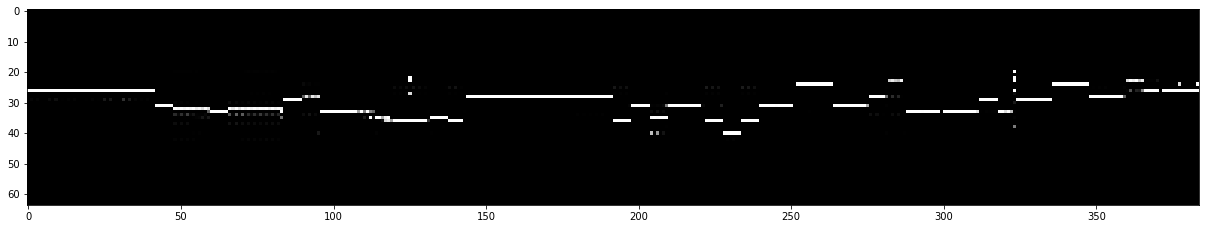

In [32]:
image_paths = glob.glob(os.path.join(save_dir, "fake_samples_*"))
image_paths.sort()

print(f"{len(image_paths)} images found in {save_dir}")
for i, path in enumerate(image_paths):
    print(f"{i}: {path.split('/')[-1]}")

image_path = image_paths[int(input("input the number of image:"))]

img = np.array(Image.open(image_path))
fig, ax = plt.subplots(figsize=(21, 7))
ax.imshow(img)

### 誤差グラフの表示

Text(0, 0.5, 'gtt')

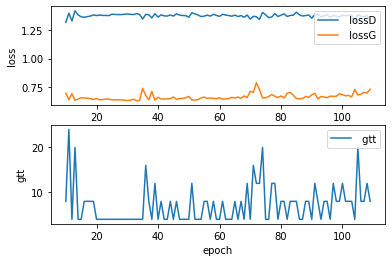

In [20]:
burn_in = 10

lossD_print = np.load(os.path.join(save_dir, 'lossD_list.npy'))[burn_in:]
lossG_print = np.load(os.path.join(save_dir, 'lossG_list.npy'))[burn_in:]
gtt_print = np.load(os.path.join(save_dir, 'gtt_list.npy'))[burn_in:]

length = lossG_print.shape[0]
length = 100
x = np.asarray(np.linspace(burn_in, burn_in + length-1, length))
fig, axs = plt.subplots(2, 1)
axs[0].plot(x, lossD_print[:length],label=' lossD', linewidth=1.5)
axs[0].plot(x, lossG_print[:length],label=' lossG', linewidth=1.5)
axs[0].legend(loc='upper right')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(x, gtt_print[:length], label=' gtt', linewidth=1.5)
axs[1].legend(loc='upper right')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('gtt')

midinet2
- 今のところ遊べるやつ
    - midinet2_dence/netG_epoch=150_nx=512_l1=1_l2=5_gt=24.pth
    - midinet2_dence/netG_epoch=0500_nz=512_l1=0.1_l2=0.5_gt=48.pth
- 1:10で学習させてもまだDが強いので，新たな[テクニック](https://qiita.com/underfitting/items/a0cbb035568dea33b2d7)を導入
    - midinet2_hacked
        - Gのforwardすべてでlreluを使用
        - DのラベルをSoftNoisyなものに変更(fakeのラベルを[0.0, 0.3], realのラベルを[0.7, 1.2]で一様分布から取得)
        - ノイズを256に増やす(条件ベクトルの10倍くらいのものが使われることが多そうなので512でもいいくらい?)
        - AdamのBeta1を0.9にして学習を加速(?)
        - ノイズを512，学習回数1:16で学習させてみる
            - 学習の記録はGのLossが段々増加，DのLossが段々現象．逆になってほしい…
            - しかし分散は小さかったので，いい線は言っていると思う
            - 生成される音楽は
                - 学習が進むほど空白が多い
                - 鳴っているところも細かい音符が多くて聞き心地が悪い
                - うまくいっている小節はメロディらしくなっているが，あまりうまくいっているものはない
                - 条件にも特に則っているようには思えない
                - epoch200になるともはや何も生成しない
            - とにかく空白が多いのがよくない．
            - 小節の1/3以上が鳴っていない楽譜を削除してみよう
            - 全てlreluにしたのは悪手だったかも．出力が消える．
    - midinet2_dense
        - 9割がon_noteである小節のみを採用したmidinet2_denseデータセットを作成して使用
        - lreluにしたところをF.leruに直した
        - もうちょいGに頑張ってほしいので1:24にしてみた
        - これは遊べる！！
            - 学習の過程も良い感じ(グラフ途中で消えちゃったけどね)
            - fillあるとめっちゃ自然になるけど，なくても結構いけるレベル
            - epochが大きくなるとCで終わってくれなくなる.150epoch辺りが聴き心地良い
    - midinet2_dense-2
        - ちゃんとしたデータが欲しかったので試しに$\lambda_1 = 0.1, \lambda_2 = 0.5$にして再挑戦
        - どの音が使われているかわかればいいので，2オクターブに押し込めるのアリな気がしてきた  
            - G3~F#5で試してみる
            - これは音飛びを減少させるのに一役買ったっぽい
        - adaptive gtt(勝手に命名)：本物を本物と識別できる奴に偽物だと見破られるほど頑張る
            - generator train times = min(36, max(1, int((avg_realD - avg_fakeD) * 100)) * k)
            - 大きい音符が多めの印象
            - k=2だとまだ安定してない感じだったので4でやってみた
            - まあ遊べるが，ちょっと細かい音符が多かったり不安定
            - 500epochs学習させてみたら割と安定してきた．
                - 16分未満の音符を削除するだけで割とちゃんとメロディになった
                - したがって，音符の切れ目を表現することができた
                - いや，down resolution後のステップの終端が空白ならそれを音符の切れ目とすることで表現できた
                - メロディにはなるんだけど，やっぱり繰り返しとかが無くて名曲にはなりにくい
            - a gttの上限を固定すると，だんだんその上限じゃ足りなくなってきて，最終的にどんなに学習してもDに勝てなくなる
            - 終わりがドなら何でもいいような気がしてきたので，自動生成する小節を指定し，終端をドにしたりできるようにした
    - というわけで多分この辺が限界なのでそろそろWGAN-gpやSAGANの勉強を始める